In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

### Reading the data

In [3]:
df = pd.read_csv('../data/sleep_health_lifestyle.csv')

In [4]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In our dataset, we would like to predict the **Quality of sleep** based on the other factors which will be the features

### Data Preparation
Lets prepare the data

##### Make all the column names small letters and replaces spaces with '_'

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['person_id', 'gender', 'age', 'occupation', 'sleep_duration',
       'quality_of_sleep', 'physical_activity_level', 'stress_level',
       'bmi_category', 'blood_pressure', 'heart_rate', 'daily_steps',
       'sleep_disorder'],
      dtype='object')

Lets look at the data to find missing values and other metrics

Numeric columns:

In [6]:
df.describe()

,person_id,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


##### Some observations:
- **Age**: The age group of individuals in the dataset is between 27-59 years.
- **Sleep Duration**: Range is between 5.8-8.5 hours.
- **Quality of sleep**: This is a subjective rating of the quality of sleep, ranging from 1 to 10. Range: 4-9.
- **Physical Activity Level**: The number of minutes the person engages in physical activity daily. Range: 30-90 mins (Everyone exercises!)
- **Stress Level**: A subjective rating of the stress level experienced by the person, ranging from 1 to 10. Range: 3-8.
- **Heart Rate**: The resting heart rate of the person in beats per minute. Range: 65-86 bpm.
- **Daily Steps**: The number of steps the person takes per day. Range: 3000-10000

##### Lets now separate the numeric columns from the categorical ones

In [7]:
df.dtypes

person_id                    int64
gender                      object
age                          int64
occupation                  object
sleep_duration             float64
quality_of_sleep             int64
physical_activity_level      int64
stress_level                 int64
bmi_category                object
blood_pressure              object
heart_rate                   int64
daily_steps                  int64
sleep_disorder              object
dtype: object

In [8]:
numerical = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64')]
numerical

Index(['person_id', 'age', 'sleep_duration', 'quality_of_sleep',
       'physical_activity_level', 'stress_level', 'heart_rate', 'daily_steps'],
      dtype='object')

In [9]:
categorical = df.columns[(df.dtypes == 'object')]
categorical

Index(['gender', 'occupation', 'bmi_category', 'blood_pressure',
       'sleep_disorder'],
      dtype='object')

Lets understand the distribution of labels in the **categorical columns**

In [10]:
for c in categorical:
    print(df[c].value_counts())
    print()

gender
Male      189
Female    185
Name: count, dtype: int64

occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Scientist                4
Software Engineer        4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

bmi_category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

blood_pressure
130/85    99
140/95    65
125/80    65
120/80    45
115/75    32
135/90    27
140/90     4
125/82     4
128/85     3
132/87     3
117/76     2
130/86     2
126/83     2
119/77     2
135/88     2
128/84     2
131/86     2
139/91     2
115/78     2
129/84     2
142/92     2
118/75     2
118/76     1
122/80     1
121/79     1
Name: count, dtype: int64

sleep_disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64



From the above categorical variables, the `blood_pressure` would be better used if it were a numeric variable. Lets separate the text into two values - the higher as `systolic` and the lower as `diastolic` and convert them into integers.

In [11]:
bp_split = df['blood_pressure'].str.split('/', expand=True)

In [12]:
df['systolic'] = bp_split[0].astype(int)
df['diastolic'] = bp_split[1].astype(int)

Lets now get rid of the `blood_pressure` column from the dataset and rearrange our **numerical** and **categorical** variables

In [13]:
del df['blood_pressure']

Let's also delete the `person_id` column because it's not a useful feature

In [14]:
del df['person_id']

We can also see that the `bmi_category` has redundant tags: *Normal* and *Normal Weight*.
Lets merge these as *Normal*

In [47]:
df.loc[df['bmi_category'] == 'Normal Weight', 'bmi_category'] = 'Normal'

In [48]:
df['bmi_category'].value_counts()

bmi_category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64

In [15]:
df.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [16]:
numerical = df.columns[(df.dtypes == 'int64') | (df.dtypes == 'float64')]
categorical = df.columns[(df.dtypes == 'object')]
numerical, categorical

(Index(['age', 'sleep_duration', 'quality_of_sleep', 'physical_activity_level',
        'stress_level', 'heart_rate', 'daily_steps', 'systolic', 'diastolic'],
       dtype='object'),
 Index(['gender', 'occupation', 'bmi_category', 'sleep_disorder'], dtype='object'))

### Exploratory Data Analysis

Lets look at the distribution of all the features by plotting them

First, we'll look at the numeric columns

In [17]:
df_num = df[numerical]

Let's plot them all

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sleep_duration'}>,
        <Axes: title={'center': 'quality_of_sleep'}>],
       [<Axes: title={'center': 'physical_activity_level'}>,
        <Axes: title={'center': 'stress_level'}>,
        <Axes: title={'center': 'heart_rate'}>],
       [<Axes: title={'center': 'daily_steps'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'diastolic'}>]], dtype=object)

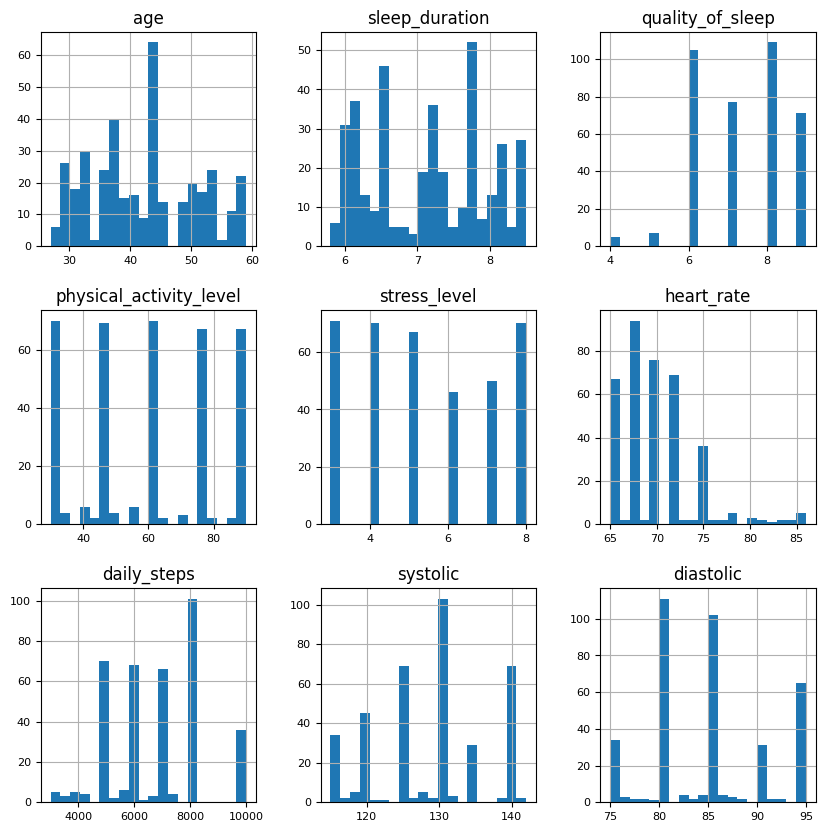

In [18]:
df_num.hist(figsize=(10,10), bins=20, xlabelsize=8, ylabelsize=8)

Lets now try the Feature to Feature relationship

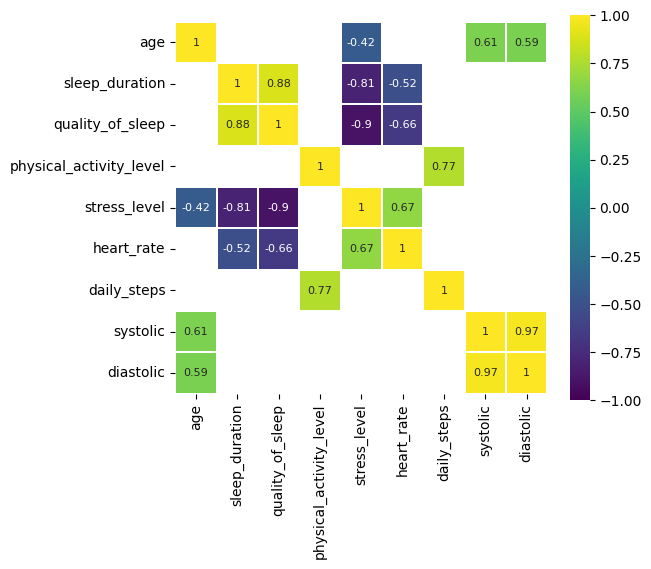

In [19]:
corr = df_num.corr()
plt.figure(figsize=(6,5))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

**Observations**
- `sleep_duration` and `quality_of_sleep` are positively correlated which means the longer one sleeps, the better the quality of sleep? We'll need to explore this further..
- `sleep_duration` and `quality_of_sleep` are negatively correlated with `stress_level`, which is expected
- `age` is positively correlated with systolic and diastolic, which means as we age the BP increases?
- `stress_level` and `heart_rate` are positively correlated

Lets now plot the numerical features against `quality_of_sleep` to see how they are correlated

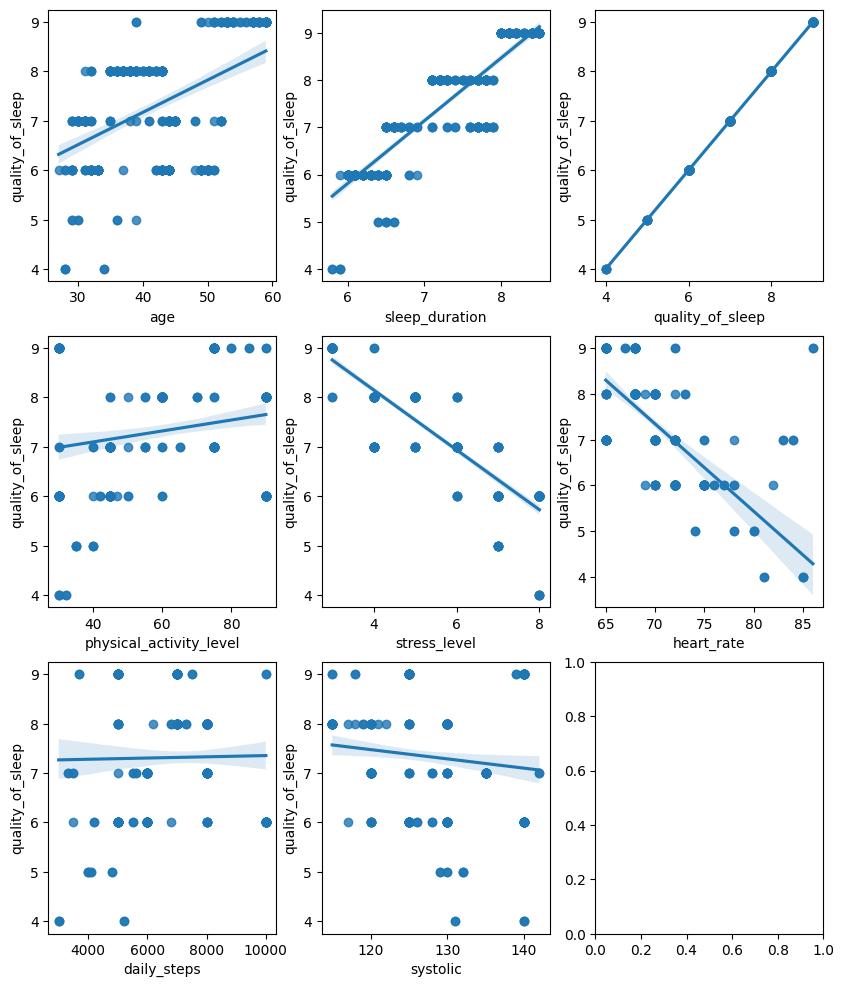

In [20]:
fig, ax = plt.subplots(round(len(numerical)/3), 3, figsize = (10,12))

for i, ax in enumerate(fig.axes):
    if i < len(numerical) -1:
        sns.regplot(x=numerical[i], y='quality_of_sleep', data=df[numerical], ax=ax)

From the above, looks like `quality_of_sleep` is: 
- positively correlated with `age` and `sleep_duration`
- negatively correlated with `stress_level` and `heart_rate`

Now let's evaluate how the categorical variables look

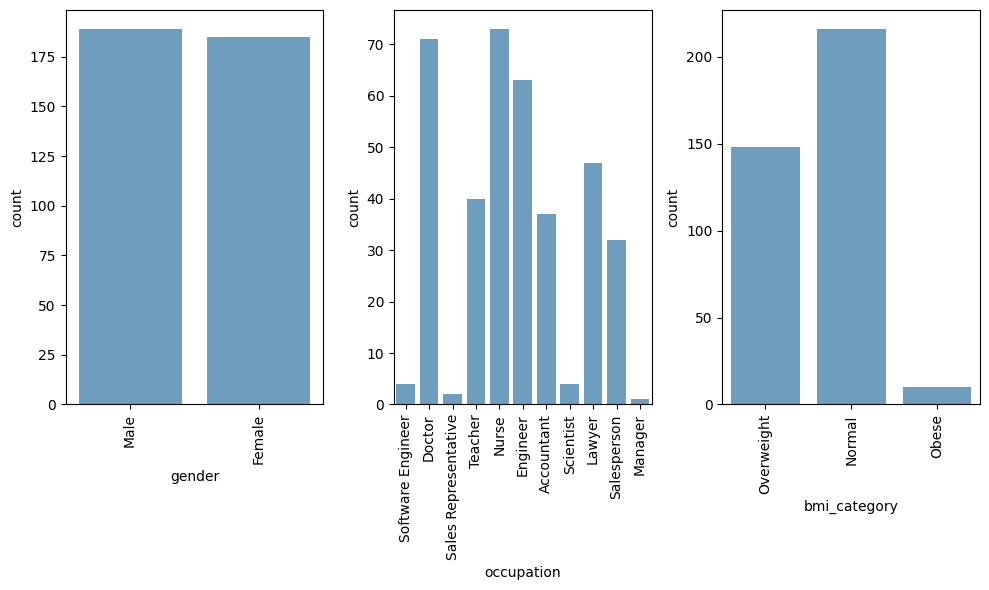

In [49]:
fig, axes = plt.subplots(round(len(categorical) / 3), 3, figsize=(10,6))

for i, ax in enumerate(fig.axes):
    if i < len(categorical):
        ax.tick_params(axis='x', rotation=90)
        sns.countplot(x=categorical[i], alpha=0.7, data=df[categorical], ax=ax)

fig.tight_layout()


Now lets plot the categorical variables against `quality_of_sleep`

##### Gender vs Quality of Sleep

([0, 1], [Text(0, 0, 'Male'), Text(1, 0, 'Female')])

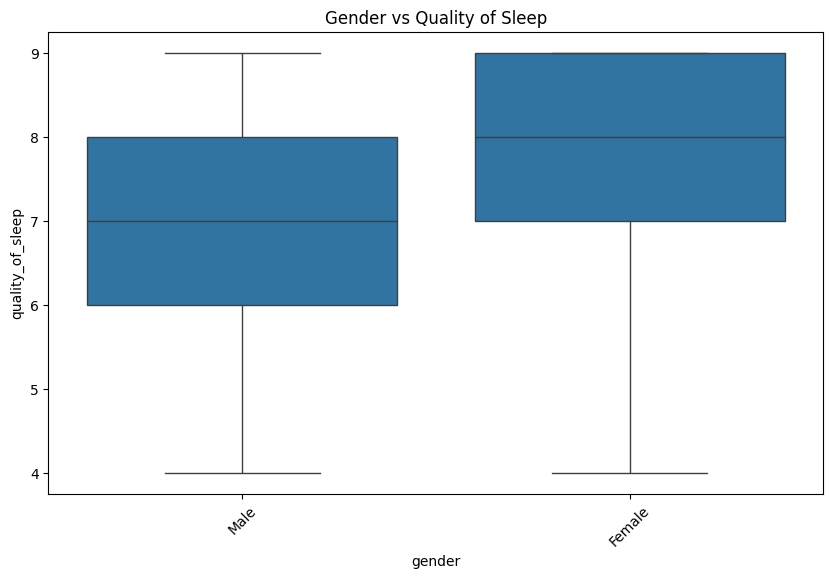

In [51]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='gender', y='quality_of_sleep', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Gender vs Quality of Sleep')
plt.xticks(rotation=45)

##### Occupation vs Quality of Sleep

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Software Engineer'),
  Text(1, 0, 'Doctor'),
  Text(2, 0, 'Sales Representative'),
  Text(3, 0, 'Teacher'),
  Text(4, 0, 'Nurse'),
  Text(5, 0, 'Engineer'),
  Text(6, 0, 'Accountant'),
  Text(7, 0, 'Scientist'),
  Text(8, 0, 'Lawyer'),
  Text(9, 0, 'Salesperson'),
  Text(10, 0, 'Manager')])

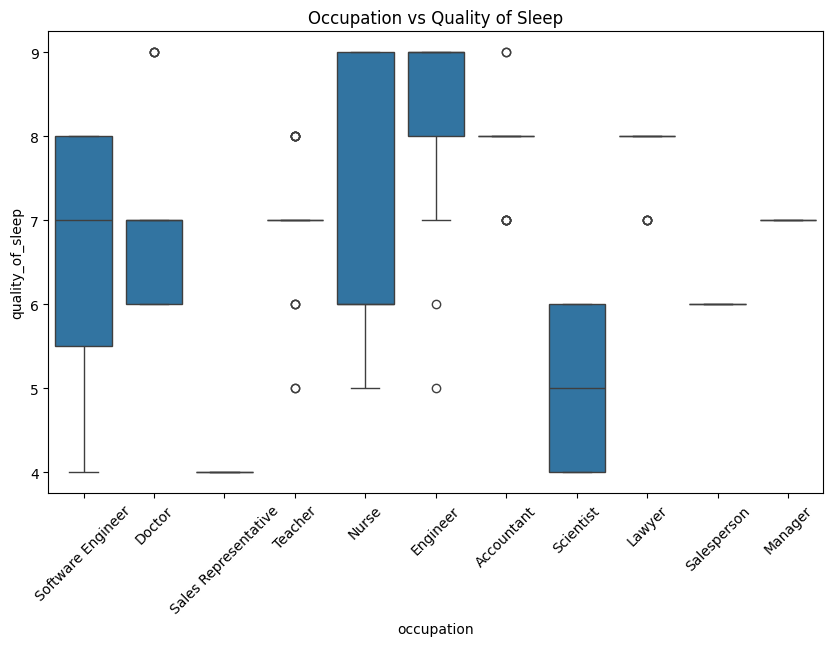

In [52]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='occupation', y='quality_of_sleep', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('Occupation vs Quality of Sleep')
plt.xticks(rotation=45)

##### BMI vs Quality of Sleep

([0, 1, 2],
 [Text(0, 0, 'Overweight'), Text(1, 0, 'Normal'), Text(2, 0, 'Obese')])

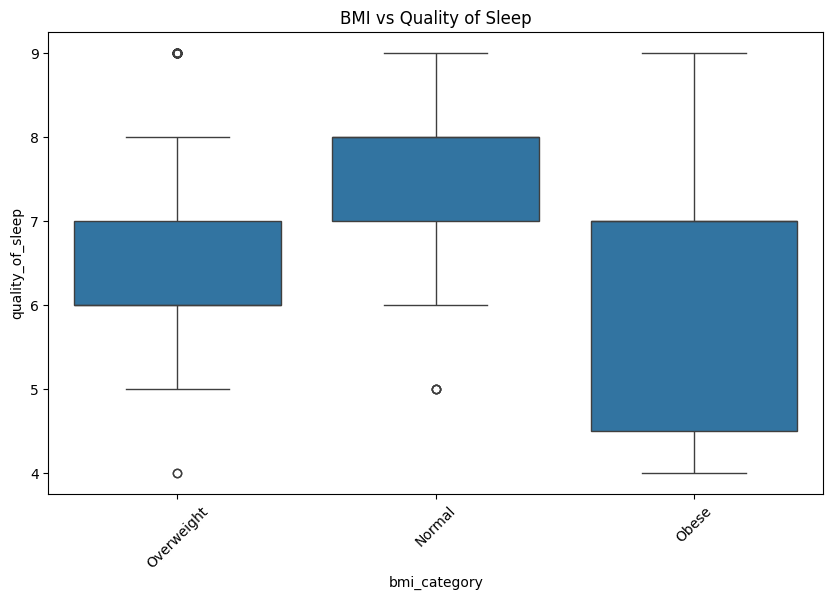

In [53]:
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='bmi_category', y='quality_of_sleep', data=df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.title('BMI vs Quality of Sleep')
plt.xticks(rotation=45)